# Projet RNN

# Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Flatten, Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report
import time
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os



# Chargement des données et définition des modèles

Le data set IMBD collecte des critiques de films sous la forme de séquence de tokens de longueur fixe. Ces critiques sont labellisées comme étant positives ou négatives. Le but de ce projet est de construire des modèles prédictifs permettant de classifier correctement les critiques.

In [4]:
vocab_size = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

On entraîne un RNN, un LSTM, un GRU, un MLP et un CNN avec des convolutions 1D. La tâche étant une classification binaire, la fonction d'activation finale est une fonction sigmoid et la fonction d'erreur est une binary cross-entropy.

In [5]:
def build_rnn():
    model = Sequential([
        Embedding(vocab_size, 32, input_length=maxlen),
        SimpleRNN(32, return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm():
    model = Sequential([
        Embedding(vocab_size, 32, input_length=maxlen),
        LSTM(32, return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru():
    model = Sequential([
        Embedding(vocab_size, 32, input_length=maxlen),
        GRU(32, return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_mlp():
    model = Sequential([
        Flatten(input_shape=(maxlen,)),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn():
    model = Sequential([
        Embedding(vocab_size, 32, input_length=maxlen),
        Conv1D(32, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Entraînement et sauvegarde des modèles

On entraîne les modèles sur 10 époques et on sélectionne les poids de la meilleure val accuracy. On enregistre également leur précision sur le data test, leur taille (nombre de paramètres) ainsi que leur temps d'entraînement. Le batch size (128) et le nombre d'époques ont été choisies car offrant de bonnes performances sur un temps réduit.

In [6]:
train = False

if train:
    if not os.path.exists("data"):
        os.makedirs("data")
    
    models = {
        "RNN": build_rnn(),
        "LSTM": build_lstm(),
        "GRU": build_gru(),
        "MLP": build_mlp(),
        "CNN": build_cnn()
    }
    
    history = {}
    results = pd.DataFrame(columns=["Model", "Training Time (s)", "Size (parameters)", "Test Accuracy"])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    for name, model in models.items():
        checkpoint = ModelCheckpoint(
            filepath=f"data/{name}_model.keras",
            monitor='val_accuracy',
            mode='max',
            save_best_only=True
        )
        
        start_time = time.time()
        history[name] = model.fit(
            x_train, y_train, 
            epochs=EPOCHS,  
            batch_size=128, 
            validation_split=0.2,
            verbose=2,
            callbacks=[checkpoint]
        )
        training_time = time.time() - start_time
        model_size = model.count_params()
        best_model = load_model(f"data/{name}_model.keras")
        test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
        results.loc[len(results)] = [name, training_time, model_size, test_accuracy]
    
    print(results)
    results.to_csv("data/results.csv", index=False)


# Chargement des modèles

In [9]:
loaded_models = {}
model_names = ["RNN", "LSTM", "GRU", "MLP", "CNN"]
for name in model_names:
    model_path = f"data/{name}_model.keras"
    if os.path.exists(model_path):
        loaded_models[name] = load_model(model_path)
        print(f"Modèle {name} chargé depuis {model_path}")
    else:
        print(f"Le fichier {model_path} est introuvable.")


results_path = "data/results.csv"
if os.path.exists(results_path):
    results = pd.read_csv(results_path)
    print("Le DataFrame results a été chargé avec succès.")
else:
    raise FileNotFoundError(f"Le fichier {results_path} est introuvable.")


2024-12-16 09:50:08.338444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10247 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1


Modèle RNN chargé depuis data/RNN_model.keras
Modèle LSTM chargé depuis data/LSTM_model.keras
Modèle GRU chargé depuis data/GRU_model.keras
Modèle MLP chargé depuis data/MLP_model.keras
Modèle CNN chargé depuis data/CNN_model.keras
Le DataFrame results a été chargé avec succès.


# Comparaisons des performances

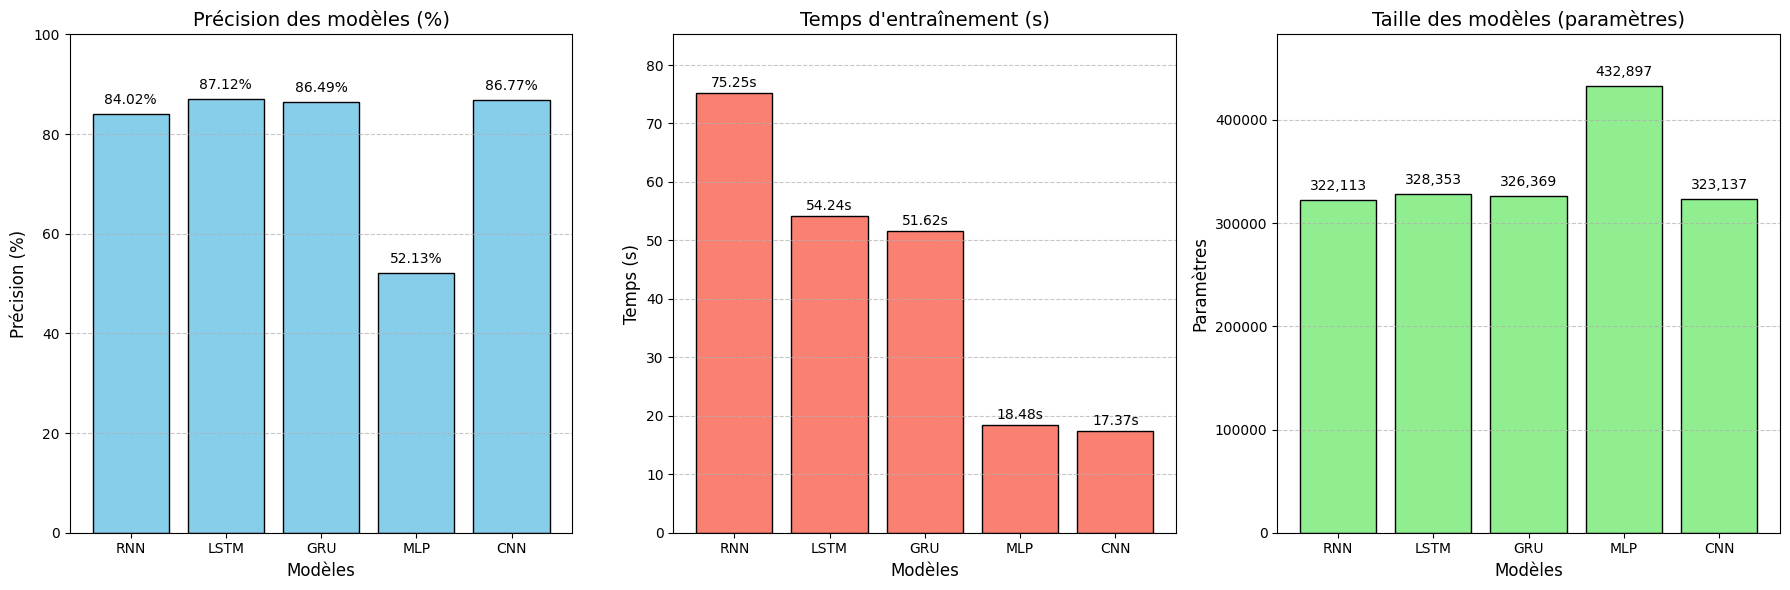

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

accuracies_percentage = [acc * 100 for acc in results["Test Accuracy"].tolist()]
axes[0].bar(results["Model"], accuracies_percentage, color='skyblue', edgecolor='black')
axes[0].set_title("Précision des modèles (%)", fontsize=14)
axes[0].set_xlabel("Modèles", fontsize=12)
axes[0].set_ylabel("Précision (%)", fontsize=12)
axes[0].set_ylim(0, 100)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for i, acc in enumerate(accuracies_percentage):
    axes[0].text(i, acc + 2, f"{acc:.2f}%", ha='center', fontsize=10)

training_times = results["Training Time (s)"].tolist()
axes[1].bar(results["Model"], training_times, color='salmon', edgecolor='black')
axes[1].set_title("Temps d'entraînement (s)", fontsize=14)
axes[1].set_xlabel("Modèles", fontsize=12)
axes[1].set_ylabel("Temps (s)", fontsize=12)
axes[1].set_ylim(0, max(training_times) + 10)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for i, time in enumerate(training_times):
    axes[1].text(i, time + 1, f"{time:.2f}s", ha='center', fontsize=10)

model_sizes = results["Size (parameters)"].tolist()
axes[2].bar(results["Model"], model_sizes, color='lightgreen', edgecolor='black')
axes[2].set_title("Taille des modèles (paramètres)", fontsize=14)
axes[2].set_xlabel("Modèles", fontsize=12)
axes[2].set_ylabel("Paramètres", fontsize=12)
axes[2].set_ylim(0, max(model_sizes) + 50000)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
for i, size in enumerate(model_sizes):
    axes[2].text(i, size + 10000, f"{size:,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## Commentaires

Les modèles récurrents ainsi que le CNN affichent des précisions équivalentes et sont à taille équivalentes. Les LSTM et GRU sont un peu plus précis que le RNN simple car leur architecture leur permet de sélectionner les informations utiles à l'inférence et éviter le vanishing gradient. On pourrait s'attendre à ce que les modèles récurrents soient plus précis que le CNN en vue de leur capacité à capturer des dépendances plus éloignées dans le temps qu'un CNN. Cependant on voit ici que des motifs locaux suffisent à capturer les sentiments. Le MLP, bien qu'ayant le plus de paramètres, ne semble pas parvenir à identifier les dépendances permettant pour prédire les sentiments, illustrant le fait que ce n'est pas un modèle adapté aux données séquentielles.

Les modèles récurrents prennent nettement plus de temps à s'entraîner que les autres modèles car le calcul de gradient n'est pas parrallélisable. En termes de mémoire, les modèles LSTM et GRU ont l’empreinte la plus importante en raison de leur architecture avancée, qui inclut des mécanismes de portes (entrée, oubli, sortie, mise à jour).

Le modèle le plus performant compte tenu de sa précision, de son temps d'entraînement et de sa taille est donc ici le CNN pour ce data set.

# Prédiction par vote majoritaire des classifieurs

Ici nous assemblons les prédictions de chaque modèle et faisons une prédiction par vote majoritaire sur le data set.

In [11]:
predictions = {}
for name, model in loaded_models.items():
    predictions[name] = model.predict(x_test)

# Moyenne des prédictions et application d'un seuil (vote majoritaire)
ensemble_predictions = (np.mean(list(predictions.values()), axis=0) > 0.5).astype(int)

I0000 00:00:1734339103.030021   14584 service.cc:146] XLA service 0x7f0f74004670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734339103.030073   14584 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-12-16 09:51:43.057915: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-16 09:51:43.111568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  7/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step

I0000 00:00:1734339103.357722   14584 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


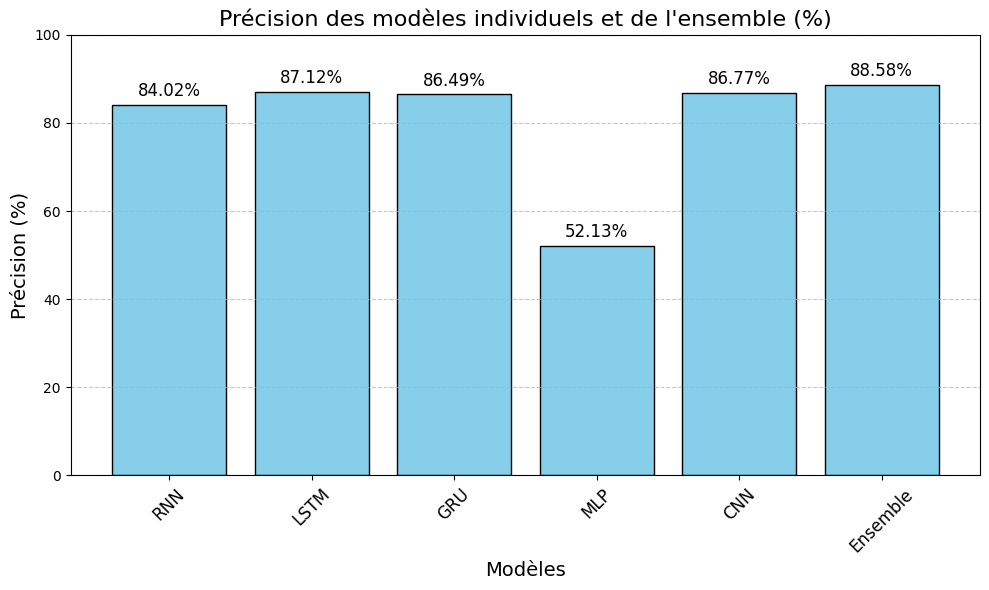

In [12]:
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

model_names = results["Model"].tolist()
accuracies = results["Test Accuracy"].tolist()
model_names.append("Ensemble")
accuracies.append(ensemble_accuracy)

accuracies_percentage = [acc * 100 for acc in accuracies]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies_percentage, color='skyblue', edgecolor='black')
plt.title("Précision des modèles individuels et de l'ensemble (%)", fontsize=16)
plt.xlabel("Modèles", fontsize=14)
plt.ylabel("Précision (%)", fontsize=14)
plt.ylim(0, 100)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, acc in enumerate(accuracies_percentage):
    plt.text(i, acc + 2, f"{acc:.2f}%", ha='center', fontsize=12)
plt.tight_layout()
plt.show()

## Commentaires

Le vote majoritaire est plus précis que chaque modèle individuellement, ce qui montre que les modèles commettent des erreurs à des moments différents.